In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
from src.utils import read_netmhcpan_results, get_filtered_df, filter_rank
from src.sequence_handling import AA_KEYS
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
pal = sns.color_palette('hsv', n_colors=13)
pal = [pal[6], pal[9], pal[-1]]
sns.set_palette(pal)
mpl.rcParams['figure.dpi'] = 180
import warnings
warnings.filterwarnings("ignore")
import h5py as h5
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

In [3]:
datadir = '../data/immunopeptidome/'
os.listdir(datadir)

['adamopoulou_supp_data_pepts_and_source_prot.xls',
 'espinosa_pep_thymus_man_extracted.txt',
 'export_hpa_thymus.tsv',
 'GSM6261174_TTA7_filtered_feature_bc_matrix.h5',
 'hp_adamo_espino_merged.txt',
 'human_thymus_atlas',
 'NOT.tsv',
 'sciimmunol.abl5053_data_file_s1.zip',
 'wang_doi 10.1126sciimmunol.abl5053.zip']

# human protein atlas web export

In [1]:
hpa_exp = pd.read_csv(datadir+'NOT.tsv', sep ='\t')
hpa_exp.drop(columns=[x for x in hpa_exp.columns if 'pig' in x or 'mouse' in x or 'brain' in x], inplace=True)
expression = hpa_exp[tissue_cols].T
expression.columns = hpa_exp['Gene description'].values
thym_expr = expression.loc[['Tissue RNA - thymus [nTPM]']].T
thym_expr.columns = ['nTPM']

NameError: name 'pd' is not defined

In [74]:
thym_expr.query('nTPM>0')

,nTPM
Alpha-2-macroglobulin,53.9
Alpha-2-macroglobulin like 1,3.0
"Alpha 1,4-galactosyltransferase (P blood group)",1.6
Aladin WD repeat nucleoporin,25.2
Acetoacetyl-CoA synthetase,10.4
...,...
ZXD family zinc finger C,10.0
"Zyg-11 family member B, cell cycle regulator",6.9
Zyxin,27.6
Zinc finger ZZ-type and EF-hand domain containing 1,15.1


In [33]:
expression.describe()

Alpha-2-macroglobulin  Alpha-2-macroglobulin like 1  \
count              53.000000                     53.000000   
mean              264.150943                     21.618868   
std               278.974343                     82.969230   
min                 5.600000                      0.000000   
25%               149.800000                      0.200000   
50%               192.700000                      0.700000   
75%               285.600000                      2.100000   
max              1678.300000                    556.300000   

       Alpha 1,4-galactosyltransferase (P blood group)  \
count                                        53.000000   
mean                                         16.315094   
std                                          15.431354   
min                                           0.300000   
25%                                           6.000000   
50%                                           7.800000   
75%                                          26.600000   
max                                          77.000000   

       Aladin WD repeat nucleoporin  Acetoacetyl-CoA synthetase  \
count                     53.000000                   53.000000   
mean                      17.915094                   11.028302   
std                        4.853642                    9.916292   
min                        7.200000                    2.400000   
25%                       14.800000                    6.000000   
50%                       17.700000                    7.800000   
75%                       19.900000                   11.000000   
max                       36.300000                   48.200000   

       Arylacetamide deacetylase  Aminoadipate aminotransferase  \
count                  53.000000                      53.000000   
mean                   33.983019                       6.420755   
std                   138.539683                       9.026017   
min                     0.000000                       0.300000   
25%                     0.000000                       2.700000   
50%                     0.200000                       5.600000   
75%                     1.500000                       6.700000   
max                   946.700000                      67.100000   

       Alpha and gamma adaptin binding protein  AP2 associated kinase 1  \
count                                53.000000                53.000000   
mean                                 18.894340                10.124528   
std                                   6.692028                12.739655   
min                                   7.200000                 0.000000   
25%                                  14.800000                 5.400000   
50%                                  18.100000                 7.700000   
75%                                  22.100000                10.300000   
max                                  35.200000                89.700000   

       Adipogenesis associated Mth938 domain containing  \
count                                         53.000000   
mean                                          57.745283   
std                                           90.950814   
min                                           13.000000   
25%                                           30.100000   
50%                                           37.200000   
75%                                           48.100000   
max                                          656.700000   

       Angio associated migratory cell protein  \
count                                53.000000   
mean                                 63.005660   
std                                  11.476019   
min                                  27.500000   
25%                                  57.400000   
50%                                  65.000000   
75%                                  67.500000   
max                                  90.400000   

       Aralkylamine N-acetyltransferase  AAR2 splicing fac

(0.0, 100.0)

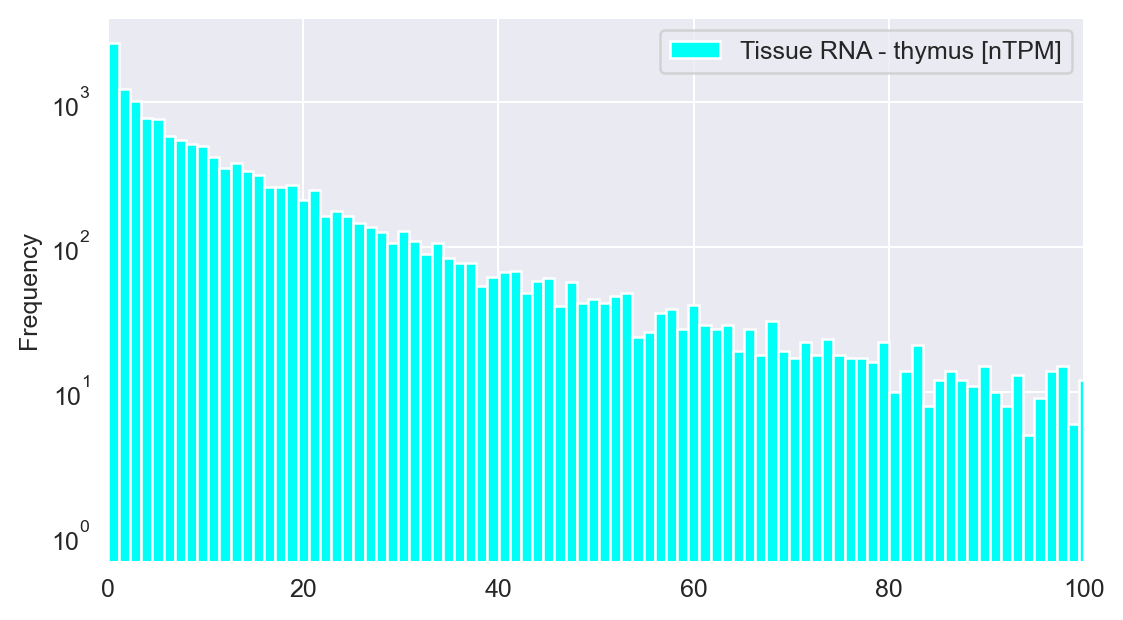

In [68]:
f,a = plt.subplots(1,1, figsize=(7,4))
thym_expr.T.plot(kind='hist', bins=7500, ax=a, logy=True)# logx=True)
a.set_xlim([0,100])

# h5 files "A cell atlas of human thymic development defines T cell repertoire formation

In [79]:
os.listdir(datadir+'human_thymus_atlas/')

['HTA08.v01.A05.Science_human_fig1.csv',
 'HTA08.v01.A05.Science_human_fig1.h5ad',
 'human_atlas_HTA07.A01.v02.entire_data_raw_count.h5ad',
 'human_atlas_thymus_annotated_matrix_files.zip',
 'human_atlas_thymus_code_package.zip',
 'human_atlas_thymus_vdj.zip',
 'sample_metadata_fix.xlsx']

# espinosa & adamopoulou (two pep found in thymus datasets)

In [132]:
with open('../data/immunopeptidome/espinosa_pep_thymus_man_extracted.txt', 'r') as f:
    lines = [x.split(' ')[0].replace('\n','') for x in f.readlines()]
pd.DataFrame(lines, columns = ['Peptide']).to_csv('../data/immunopeptidome/espinosa_pep_thymus_man_extracted.txt', index=False)

In [135]:
espinosa = pd.read_csv('../data/immunopeptidome/espinosa_pep_thymus_man_extracted.txt')

In [146]:
ad_xls = pd.ExcelFile('../data/immunopeptidome/adamopoulou_supp_data_pepts_and_source_prot.xls')

In [188]:
adamo = []
for i in range(len(ad_xls.sheet_names)):
    nskip = 5 if i<4 else 6
    tp = pd.read_excel(ad_xls, i, skiprows=nskip)
    tp.columns=['Peptide', 'Mass', 'HLA', 'Gene', 'Source Protein']
    adamo.append(tp)
adamo = pd.concat(adamo).dropna(subset='Peptide', axis=0)
adamo = adamo.query('not `HLA`.str.contains("D")', engine='python')

In [221]:
adamo

,Peptide,Mass,HLA,Gene,Source Protein
0,AEFEWENKV,1150.53,B*49:01,COPB1,Coatomer subunit beta
1,AERPGEAAV,898.45,B*49:01,MARCKS,Myristoylated alanine-rich C-kinase substrate
2,AEVLEAHTI,981.51,B*49:01,ZNFX1,NFX1-type zinc finger-containing protein 1
3,DAAEIRLV,885.49,B*51,NCL,Nucleolin
4,DAARFPII,901.50,B*51,HM13,Minor histocompatibility antigen H13
...,...,...,...,...,...
42,VMAPRTLIL,1012.61,HLA-E,HLA-C,"HLA class I histocompatibility antigen, Cw-3 a..."
43,VMAPRTLLL,1012.61,HLA-E,HLA-A,"HLA class I histocompatibility antigen, A-1 al..."
44,VMAPRTLVL,998.59,HLA-E,HLA-A,"HLA class I histocompatibility antigen, A-2 al..."
45,VMAPRTLIL,1012.61,HLA-E,HLA-C,"HLA class I histocompatibility antigen, Cw-3 a..."


In [216]:
merged=pd.concat([adamo[['Peptide']], espinosa])
merged['len'] = merged['Peptide'].apply(len)
merged = merged.query('len>=8 and len <=12')
counts = merged.groupby('Peptide')['len'].count()
merged['agg_label'], merged['percentage_pos'] = 0, 0 
merged=merged.drop_duplicates(keep='first')
merged['total_count']=counts.values

In [220]:
merged.to_csv('../data/immunopeptidome/hp_adamo_espino_merged.txt', index=False)